### Imports

In [1]:
# !pip install pandas matplotlib numpy
# !pip install pyyaml==5.3
# !pip install pygments==2.4.1

In [2]:
# %pip install pandas
# %pip install matplotlib seaborn scikit-learn 
# %pip install wordcloud

In [3]:
# %pip install nltk

In [4]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
# from skmultilearn.adapt import mlknn
# from skmultilearn.problem_transform import ClassifierChain
# from skmultilearn.problem_transform import BinaryRelevance
# from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Stack Overflow: Tag Prediction

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h1> Exploratory Data Analysis </h1>

<h2> Data Loading and Cleaning </h2>

In [6]:
# Loading the data into a pandas dataframe
df_train = pd.read_csv("Train_100k.csv")
df_train.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


<h3>Checking for duplicates </h3>

In [7]:
import pandas as pd
from datetime import datetime

# Assuming `df` already contains the data from the database
start = datetime.now()

# Group by Title, Body, and Tags, and count duplicates
df_no_dup = df_train.groupby(['Title', 'Body', 'Tags'], as_index=False).size().rename(columns={'size': 'cnt_dup'})

print("Time taken to run this cell:", datetime.now() - start)


Time taken to run this cell: 0:00:00.430924


In [12]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1
1,Encoding of sent data not working,"<p>I've got a little chatbox, everything's wor...",php jquery ajax encoding,1
2,"Files in Array, in Array to Tree?","<p>Using <code>C#</code>, I have created a pro...",c# visual-studio-2010 visual-studio-2008 clear...,1
3,Google Map location based on address,"<p>Im using Google Map in my application, it i...",android google-maps,1
4,How to insert custom field in typo3 Dam modul...,<p>I introduced my custom field in Dam modules...,typo3 dam,1


In [13]:
# Calculate the total number of rows in the original DataFrame
total_rows = len(df_train)

# Calculate the number of duplicate questions
num_duplicates = total_rows - df_no_dup.shape[0]

# Calculate the percentage of duplicates
duplicate_percentage = (1 - (df_no_dup.shape[0] / total_rows)) * 100

# Print the result
print(f"Number of duplicate questions: {num_duplicates} ({duplicate_percentage:.2f}%)")


Number of duplicate questions: 564 (0.56%)


In [8]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

cnt_dup
1    98874
2      560
3        2
Name: count, dtype: int64

In [9]:
start = datetime.now()
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:00.047124


,Title,Body,Tags,cnt_dup,tag_count
0,Accessing @Local Session Bean from an exposed...,<p>What I am trying to do should be very strai...,ejb resteasy,1,2
1,Encoding of sent data not working,"<p>I've got a little chatbox, everything's wor...",php jquery ajax encoding,1,4
2,"Files in Array, in Array to Tree?","<p>Using <code>C#</code>, I have created a pro...",c# visual-studio-2010 visual-studio-2008 clear...,1,4
3,Google Map location based on address,"<p>Im using Google Map in my application, it i...",android google-maps,1,2
4,How to insert custom field in typo3 Dam modul...,<p>I introduced my custom field in Dam modules...,typo3 dam,1,2


In [10]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

tag_count
3    28603
2    26384
4    19009
1    13784
5    11656
Name: count, dtype: int64

<h2> Analysis of Tags </h2>

<h3> Total number of unique tags </h3>

In [11]:
# Importing & Initializing the "CountVectorizer" object, which
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(df_no_dup['Tags'])

In [12]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 99436
Number of unique tags : 18448


In [15]:
# Use get_feature_names_out() instead of get_feature_names()
tags = vectorizer.get_feature_names_out()

# Let's look at the tags we have
print("Some of the tags we have:", tags[:10])


Some of the tags we have: ['.a' '.bash-profile' '.class-file' '.each' '.emf' '.hgtags' '.htaccess'
 '.htpasswd' '.mov' '.net']


<h3> Number of times a tag appeared </h3>

In [16]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [17]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,2
1,.bash-profile,1
2,.class-file,1
3,.each,6
4,.emf,2


In [21]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

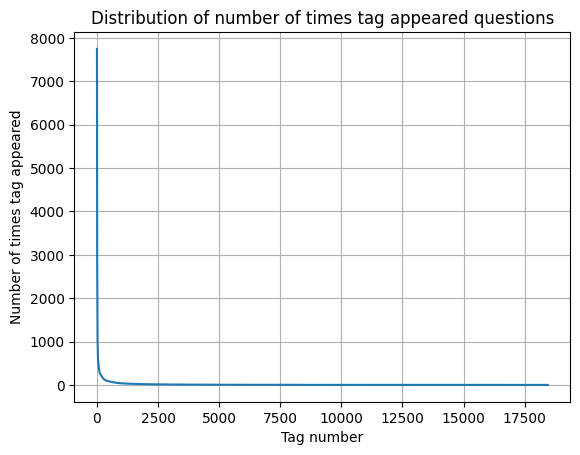

In [22]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

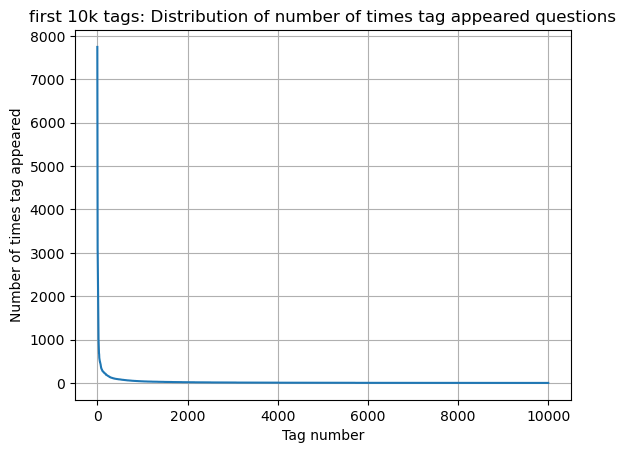

400 [7745  996  538  412  314  264  237  218  188  171  156  138  126  119
  110  104   97   93   90   85   83   79   75   73   69   66   64   60
   59   56   54   52   50   48   47   45   44   42   41   40   39   37
   37   36   35   34   33   32   32   31   31   30   29   29   28   28
   27   27   26   26   25   25   24   24   23   23   23   22   22   21
   21   21   20   20   20   20   19   19   19   18   18   18   18   17
   17   17   17   16   16   16   16   15   15   15   15   15   14   14
   14   14   14   13   13   13   13   13   13   13   12   12   12   12
   12   12   12   11   11   11   11   11   11   11   11   11   10   10
   10   10   10   10   10   10   10   10   10    9    9    9    9    9
    9    9    9    9    9    9    9    8    8    8    8    8    8    8
    8    8    8    8    8    8    8    7    7    7    7    7    7    7
    7    7    7    7    7    7    7    7    7    7    7    6    6    6
    6    6    6    6    6    6    6    6    6    6    6    6    6    6
  

In [21]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

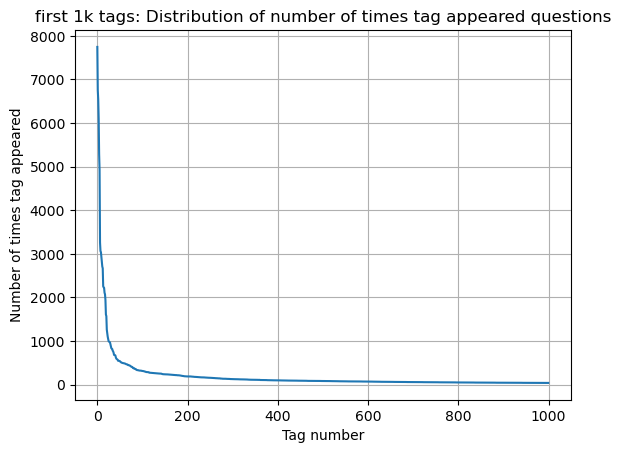

200 [7745 4925 2818 2222 1570  996  879  763  669  571  538  499  486  465
  444  412  379  357  331  322  314  300  287  274  268  264  260  255
  252  240  237  234  229  224  219  218  214  207  200  191  188  187
  183  178  175  171  167  166  162  159  156  153  150  147  143  138
  135  134  130  128  126  125  123  121  120  119  118  115  112  111
  110  109  109  106  105  104  102  100   99   98   97   97   96   95
   94   93   92   92   91   90   90   89   89   87   86   85   85   84
   84   83   83   82   81   81   80   79   78   77   76   76   75   74
   74   74   73   73   72   72   70   70   69   69   68   68   67   66
   65   65   65   64   64   63   62   61   61   60   60   59   59   59
   59   58   58   57   57   56   56   56   55   55   54   54   53   53
   52   52   51   51   51   50   50   50   49   49   49   48   48   47
   47   47   47   46   46   46   45   45   45   44   44   44   44   44
   43   43   43   42   42   42   42   41   41   41   40   40   40   40
  

In [22]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

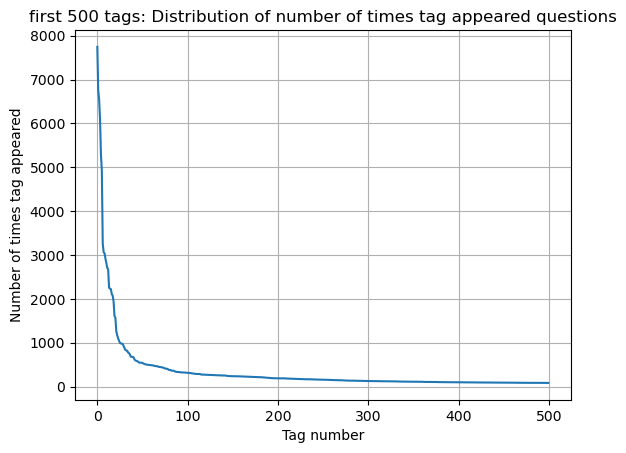

100 [7745 4925 2818 2222 1570  996  879  763  669  571  538  499  486  465
  444  412  379  357  331  322  314  300  287  274  268  264  260  255
  252  240  237  234  229  224  219  218  214  207  200  191  188  187
  183  178  175  171  167  166  162  159  156  153  150  147  143  138
  135  134  130  128  126  125  123  121  120  119  118  115  112  111
  110  109  109  106  105  104  102  100   99   98   97   97   96   95
   94   93   92   92   91   90   90   89   89   87   86   85   85   84
   84   83]


In [30]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

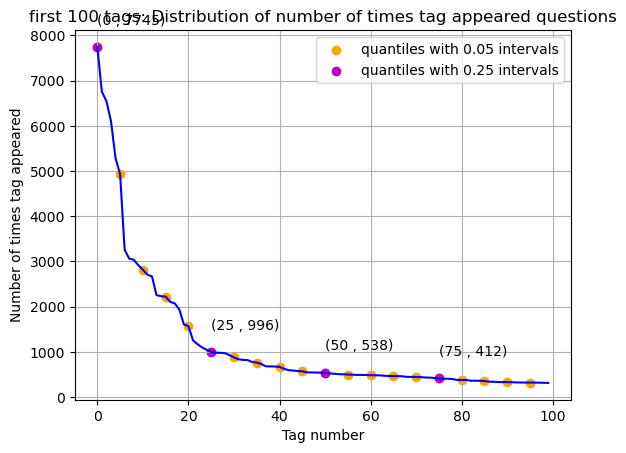

20 [7745 4925 2818 2222 1570  996  879  763  669  571  538  499  486  465
  444  412  379  357  331  322]


In [23]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x, y in zip(list(range(0, 100, 25)), tag_counts[0:100:25]):
    plt.annotate("({} , {})".format(x, y), xy=(x, y), xytext=(x - 0.05, y + 500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

<h3> Tags Per Question </h3>

In [18]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting each value in the 'tag_quest_count' to integer.
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 99436 datapoints.
[2, 4, 4, 2, 2]


In [19]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.883030


<h3>Most Frequent Tags </h3>

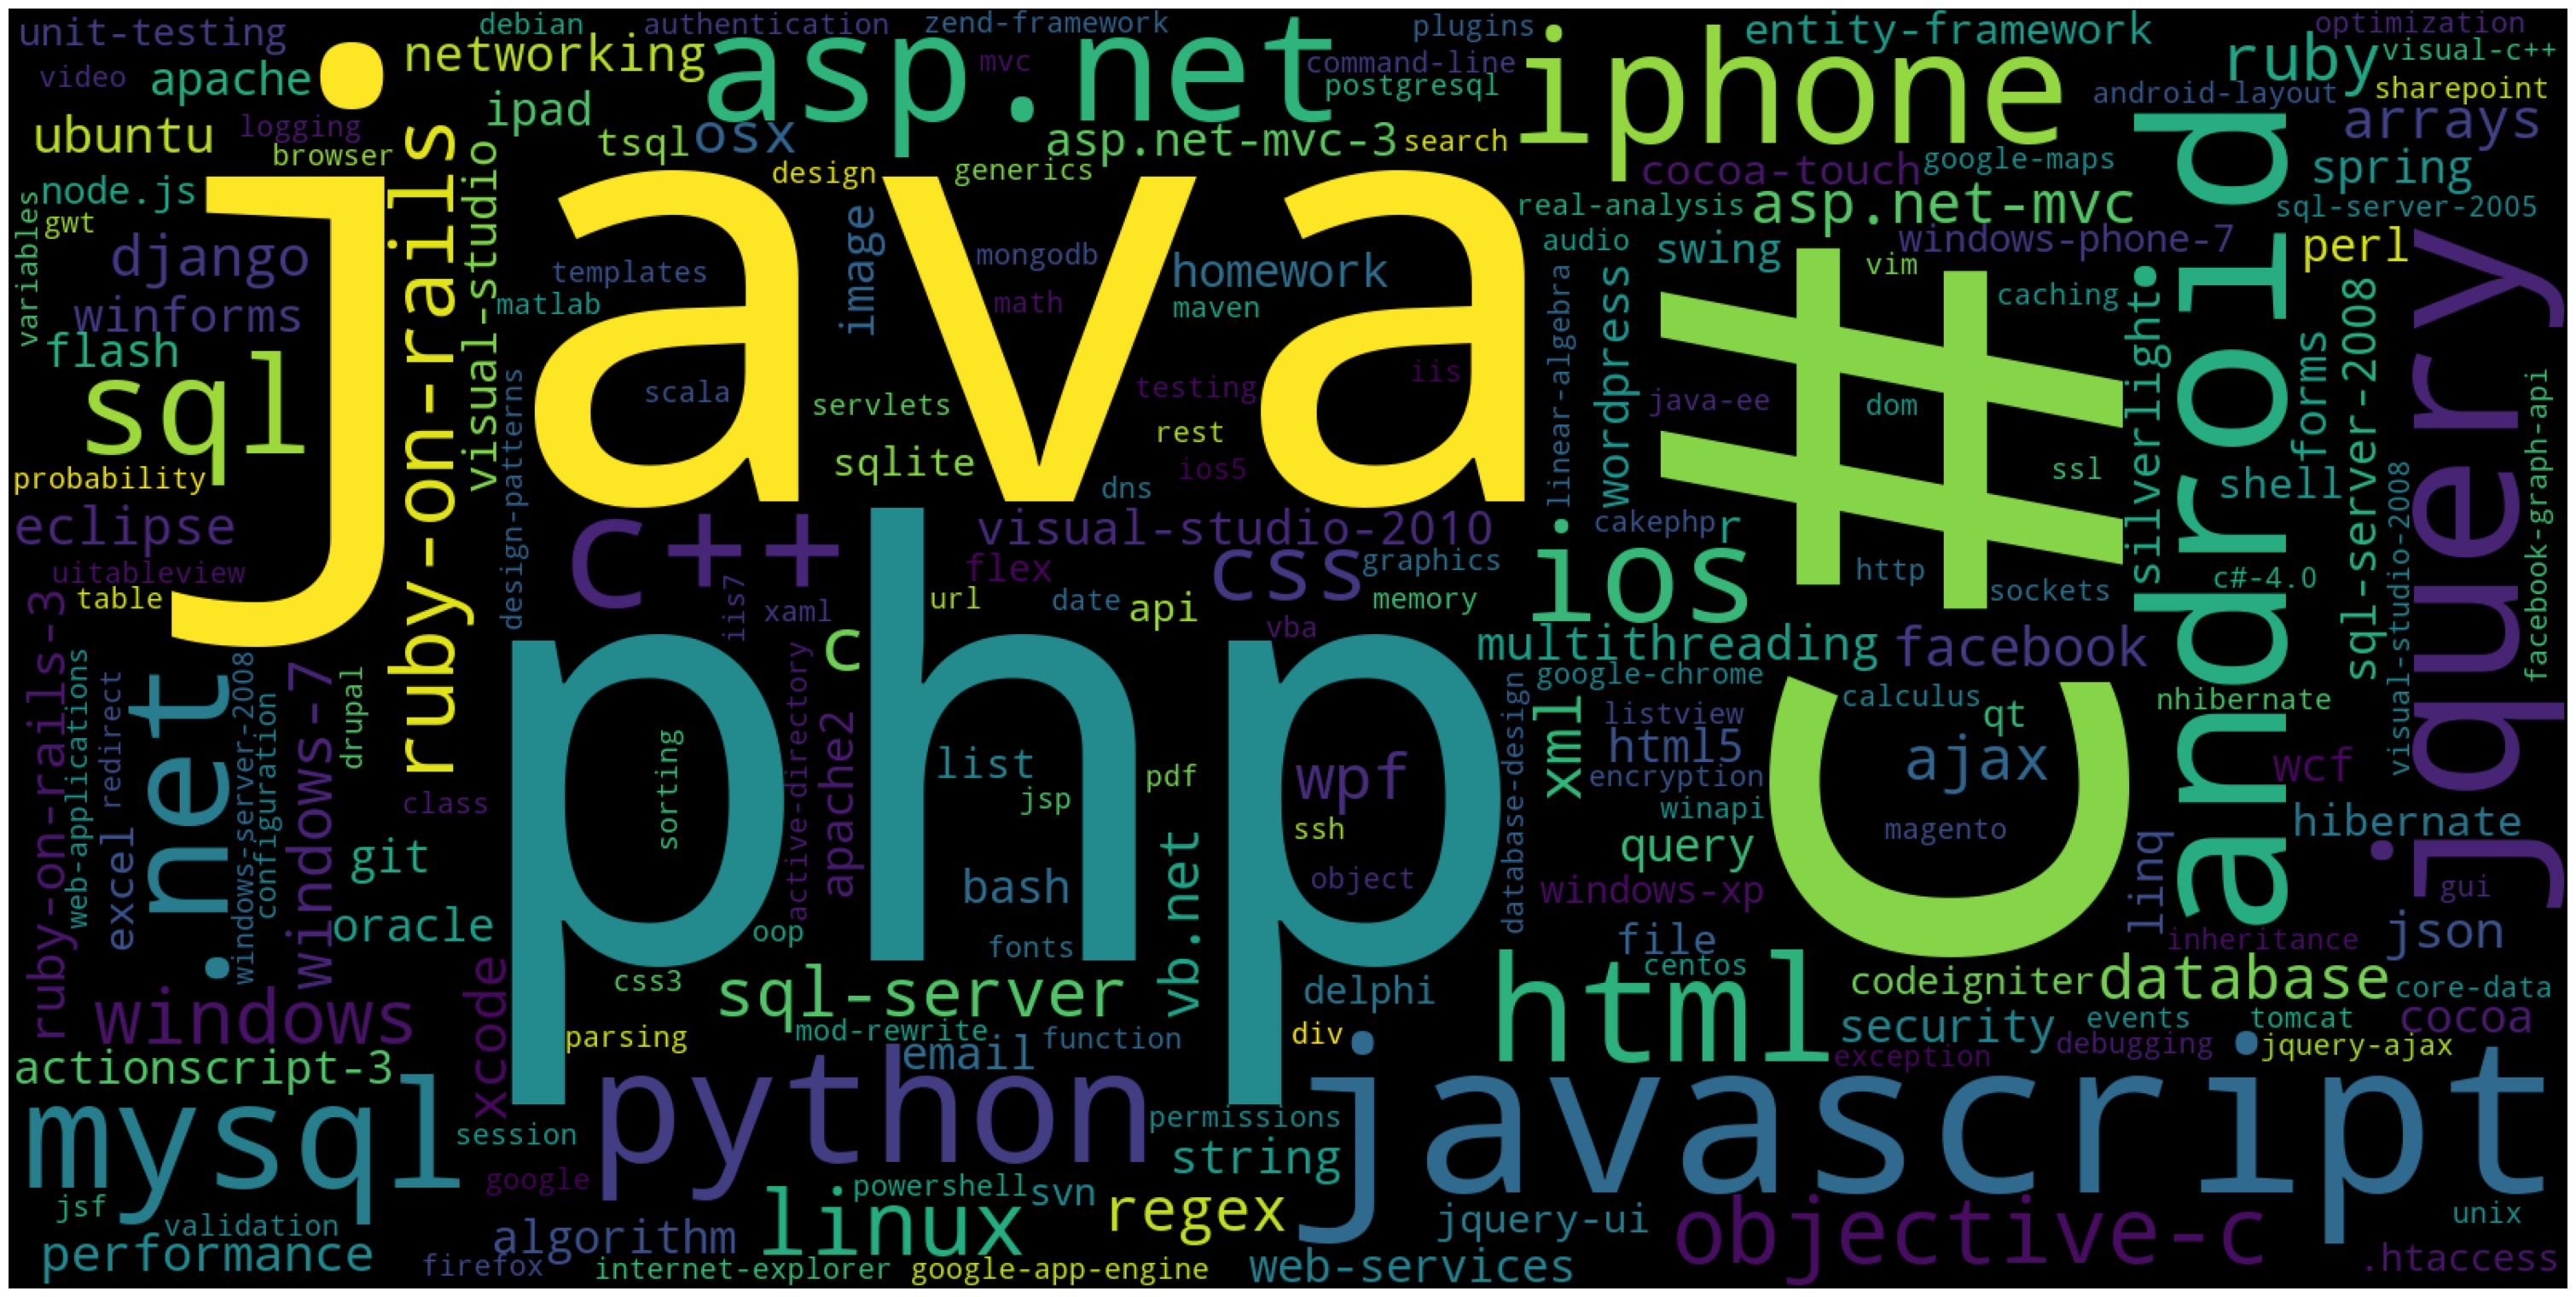

Time taken to run this cell : 0:00:02.377259


In [24]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> The top 20 tags </h3>

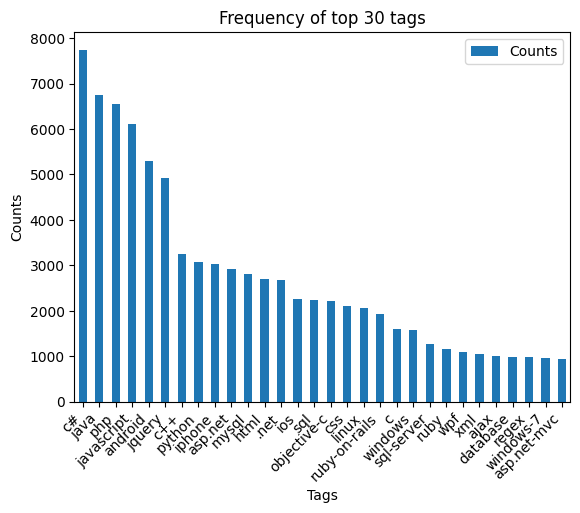

In [23]:
# Plot the top 30 tags
tag_df_sorted.head(30).plot(kind='bar')

# Set the title, x-label, and y-label
plt.title('Frequency of top 30 tags')
plt.xlabel('Tags')
plt.ylabel('Counts')

# Set the x-ticks with correct labels
plt.xticks(ticks=range(30), labels=tag_df_sorted['Tags'].head(30), rotation=45, ha='right')

# Show the plot
plt.show()


<h3> Cleaning and preprocessing of Questions </h3>

<h3> Preprocessing </h3>

In [27]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vaibhav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vaibhav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
import pandas as pd
import re
from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Initialize objects
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Helper function to remove HTML tags
def striphtml(data):
    """Remove HTML tags from a string."""
    return BeautifulSoup(data, "html.parser").get_text()

# Start timer
start = datetime.now()

# Limit the dataset to 100,000 random samples
df_sampled = df_no_dup.sample(n=90000, random_state=42)

# Pre-compile regular expressions
code_pattern = re.compile(r'<code>(.*?)</code>', flags=re.DOTALL)
non_alphanumeric_pattern = re.compile(r'[^A-Za-z]+')

# Function to process each row
def process_row(row):
    title, question, tags = row['Title'], row['Body'], row['Tags']
    is_code = 0  # Flag for code presence

    # Check for code in the question and extract code if present
    if '<code>' in question:
        is_code = 1

    code = str(code_pattern.findall(question))
    question = re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE | re.DOTALL)
    question = striphtml(question)

    # Combine title and question
    combined_text = str(title) + " " + str(question)
    combined_text = non_alphanumeric_pattern.sub(' ', combined_text)  # Remove non-alphanumeric characters
    words = word_tokenize(combined_text.lower())

    # Remove stopwords and single characters (except 'c')
    processed_text = ' '.join(
        str(stemmer.stem(word)) for word in words if word not in stop_words and (len(word) != 1 or word == 'c')
    )

    return processed_text, code, tags, len(combined_text), len(processed_text), is_code

# Apply processing to the DataFrame (parallelized for speed)
processed_data = df_sampled.apply(process_row, axis=1)

# Extract processed data into lists
processed_questions, codes, tags_list, words_pre, words_post, is_code_flags = zip(*processed_data)

# Create a new DataFrame with processed data
processed_df = pd.DataFrame({
    'question': processed_questions,
    'code': codes,
    'tags': tags_list,
    'words_pre': words_pre,
    'words_post': words_post,
    'is_code': is_code_flags,
})

# Save the processed DataFrame to a CSV or database if needed
processed_df.to_csv("Processed_Questions.csv", index=False)

# Calculate statistics
avg_len_pre = sum(words_pre) / len(words_pre)
avg_len_post = sum(words_post) / len(words_post)
percent_with_code = (sum(is_code_flags) * 100.0) / len(is_code_flags)

# Print statistics
print(f"Avg. length of questions (Title + Body) before processing: {avg_len_pre:.2f}")
print(f"Avg. length of questions (Title + Body) after processing: {avg_len_post:.2f}")
print(f"Percent of questions containing code: {percent_with_code:.2f}%")

# Print total time taken
print("Time taken to run this cell:", datetime.now() - start)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vaibhav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vaibhav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vaibhav/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Avg. length of questions (Title + Body) before processing: 553.94
Avg. length of questions (Title + Body) after processing: 324.97
Percent of questions containing code: 56.07%
Time taken to run this cell: 0:00:47.757817


In [29]:
processed_df.head()

,question,code,tags,words_pre,words_post,is_code
0,gridview insid ajax updatepanel refresh delet ...,"[' &lt;ajax:UpdatePanel ID=""UserAccessGridU...",c# gridview updatepanel,285,170,1
1,invok dnsapi dll method dnsvalidateserverstatu...,[],c# pinvoke,608,377,0
2,recal displi nsstring hello im sure answer bug...,"['didSelectRowAtIndexPath', '- (void)tableView...",ios nsstring nslog recall,589,313,1
3,revers quin written c programm print time get ...,"['hello\n', '""olleh"" for n=1', '#include &lt;s...",c quine,224,106,1
4,class file get creat java class load jvm dynam...,"['Class', '.class', 'test3', 'class test1 {\n ...",java class javac,387,202,1


In [30]:
print("number of data points in sample :", processed_df.shape[0])
print("number of dimensions :", processed_df.shape[1])

number of data points in sample : 90000
number of dimensions : 6


<h1>Machine Learning Models </h1>

<h2> Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [31]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=True)
multilabel_y = vectorizer.fit_transform(processed_df['tags'])

### Narrowing down the top most frequent tags

In [32]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x = multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [33]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=processed_df.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

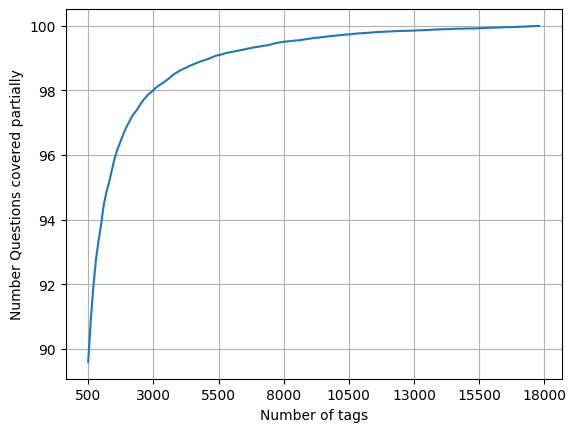

with  5500 tags we are covering  99.096 % of questions


In [34]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions covered partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [35]:
multilabel_yx = tags_to_choose(50)
print("number of questions that are not covered :", questions_explained_fn(50),"out of ", total_qs)

number of questions that are not covered : 29424 out of  90000


In [36]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 17804
number of tags taken : 50 ( 0.2808357672433161 %)


<h2> Split the data into test and train (80:20) </h2>

In [37]:
total_size=processed_df.shape[0]
train_size=int(0.80*total_size)

x_train=processed_df.head(train_size)
x_test=processed_df.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [38]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (72000, 50)
Number of data points in test data : (18000, 50)


<h2> Modeling with fewer data points (100k) and narrowing down the top most(50, 100, 1000) frequent tags. </h2>

## TFIDF count vectorizer

In [87]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x.split(),
    max_features=1000,
    ngram_range=(1, 2),
    stop_words='english'
)

# Fit on the training data
x_train_tfidf = vectorizer.fit_transform(x_train['question'])  # Fit and transform train data

# Transform the test data using the same vectorizer
x_test_tfidf = vectorizer.transform(x_test['question'])        # Transform test data


### Predicting tags using Cosine similarity between TFIDF vectors of questions and tags

In [84]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

def predict_tags(x_test_tfidf, x_train_tfidf, y_train, top_n=5, num_similar=3):
    """
    Predict tags for x_test based on cosine similarity with x_train.
    Args:
        x_test_tfidf: Sparse TF-IDF matrix for test data.
        x_train_tfidf: Sparse TF-IDF matrix for train data.
        y_train: Multilabel binary sparse matrix of train tags.
        top_n: Number of top tags to predict for each test example.
        num_similar: Number of most similar train examples to consider.
    Returns:
        List of predicted tag indices for each test example.
    """
    predictions = []

    # Compute cosine similarity between test and train data (use sparse matrix optimization)
    similarity_matrix = cosine_similarity(x_test_tfidf, x_train_tfidf)  # Result will be a 2D matrix

    # Ensure similarity_matrix has the shape (num_test_samples, num_train_samples)
    assert similarity_matrix.ndim == 2, "Similarity matrix should be a 2D array"

    # Iterate through each test sample and find the most similar train samples
    for i in range(similarity_matrix.shape[0]):
        # Get the similarity scores for the i-th test sample against all train samples
        similarity_scores = similarity_matrix[i]

        # Get the indices of the top `num_similar` most similar train samples
        top_similar_indices = np.argsort(-similarity_scores)[:num_similar]

        # Aggregate tags from the most similar train examples using sparse sum
        similar_tags = np.zeros(y_train.shape[1])  # Initialize a zero vector to hold the aggregated tags

        for idx in top_similar_indices:
            # Efficiently aggregate the tags of the top similar training samples
            similar_tags += y_train[idx].toarray().flatten()  # Convert sparse to dense for this row only

        # Rank tags by frequency and select the top_n tags
        top_tags = np.argsort(-similar_tags)[:top_n]

        predictions.append(top_tags)

    return predictions


### Predicting tags using weighted TF-IDF vectors with Similarity between train and test question vectors

In [85]:
def predict_tags(x_test_tfidf, x_train_tfidf, y_train, num_similar=5, top_n=5, threshold=0.2):
    predictions = []

    # Compute cosine similarity
    similarity_matrix = cosine_similarity(x_test_tfidf, x_train_tfidf)

    for i in range(similarity_matrix.shape[0]):
        similarity_scores = similarity_matrix[i]

        # Get top `num_similar` most similar train samples
        top_similar_indices = np.argsort(-similarity_scores)[:num_similar]

        # Aggregate tags with weights
        weighted_tags = np.zeros(y_train.shape[1])
        for idx in top_similar_indices:
            weight = similarity_scores[idx]
            weighted_tags += weight * y_train[idx].toarray().flatten()

        # Select top tags based on weight
        top_tags = np.argsort(-weighted_tags)[:top_n]
        predicted_tags = top_tags[weighted_tags[top_tags] > threshold]
        predictions.append(predicted_tags)

    return predictions


In [47]:
predictions = predict_tags(x_test_tfidf, x_train_tfidf, y_train, top_n=5, num_similar=5)

predictions

,question,code,tags,words_pre,words_post,is_code
0,gridview insid ajax updatepanel refresh delet ...,"[' &lt;ajax:UpdatePanel ID=""UserAccessGridU...",c# gridview updatepanel,285,170,1
1,invok dnsapi dll method dnsvalidateserverstatu...,[],c# pinvoke,608,377,0
2,recal displi nsstring hello im sure answer bug...,"['didSelectRowAtIndexPath', '- (void)tableView...",ios nsstring nslog recall,589,313,1
3,revers quin written c programm print time get ...,"['hello\n', '""olleh"" for n=1', '#include &lt;s...",c quine,224,106,1
4,class file get creat java class load jvm dynam...,"['Class', '.class', 'test3', 'class test1 {\n ...",java class javac,387,202,1
...,...,...,...,...,...,...
71995,nsi hklm use string use wizard creat nsi insta...,"['!define PRODUCT_UNINST_ROOT_KEY ""HKLM""\n', '...",installer windows-installer nsis,364,232,1
71996,set carret posit text field win api creat text...,[],c++ winapi,193,115,0
71997,function tri understand necessari modul use re...,"[""parseResponse = (response, cb) -&gt; \n out...",javascript coffeescript,174,71,1
71998,zend search lucen rebuild index wonder anybodi...,[],zend-framework search lucene reindex,922,511,0


## Evaluating tags predicted (Precision@k, Recall@k, F1@k)

In [88]:
def evaluate_content_based_tfidf(x_test_tfidf, y_test, x_train_tfidf, y_train, top_n=5, num_similar=4):
    """
    Evaluate the content-based filtering model using the optimized prediction function.

    Args:
    - x_test_tfidf (sparse matrix): TF-IDF matrix for test questions.
    - y_test (sparse matrix): Tag matrix for test questions.
    - x_train_tfidf (sparse matrix): TF-IDF matrix for train questions.
    - y_train (sparse matrix): Tag matrix for train questions.
    - top_n (int): Number of top tags to predict.
    - num_similar (int): Number of similar training questions to consider.

    Returns:
    - metrics (dict): Dictionary containing Precision@k, Recall@k, and F1@k.
    """
    # Get predictions using the optimized prediction function
    predictions = predict_tags(x_test_tfidf, x_train_tfidf, y_train, top_n, num_similar)

    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_test_samples = y_test.shape[0]

    for i in range(total_test_samples):
        # Get true tags as a set of indices where the y_test value is greater than zero
        true_tags = set(np.where(y_test[i].toarray()[0] > 0)[0])

        # Ensure predictions[i] is a list or array of indices (and not a sparse matrix or non-hashable object)
        predicted_tags = set(predictions[i])  # predictions[i] should be a list of indices

        # Calculate Precision@k
        if len(predicted_tags) > 0:
            precision = len(true_tags & predicted_tags) / len(predicted_tags)
        else:
            precision = 0

        # Calculate Recall@k
        if len(true_tags) > 0:
            recall = len(true_tags & predicted_tags) / len(true_tags)
        else:
            recall = 0

        # Calculate F1@k
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0

        # Accumulate metrics
        total_precision += precision
        total_recall += recall
        total_f1 += f1

    # Average metrics across all test samples
    metrics = {
        "Precision@k": total_precision / total_test_samples,
        "Recall@k": total_recall / total_test_samples,
        "F1@k": total_f1 / total_test_samples,
    }

    return metrics

# Evaluate the optimized model
metrics = evaluate_content_based_tfidf(
    x_test_tfidf, y_test, x_train_tfidf, y_train, top_n=5, num_similar=3
)
print(f"Precision@5: {metrics['Precision@k']:.2f}")
print(f"Recall@5: {metrics['Recall@k']:.2f}")
print(f"F1@5: {metrics['F1@k']:.2f}")


Precision@5: 0.19
Recall@5: 0.34
F1@5: 0.23


## Predicting tags with transformer based model embeddings

In [39]:
%pip install transformers
%pip install sentence-transformers
%pip install einops

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached einops-0.8.0-py3-none-any.whl.metadata (12 kB)
Using cached einops-0.8.0-py3-none-any.whl (43 kB)
Note: you may need to restart the kernel to use updated packages.


In [41]:
from transformers import RobertaTokenizer, RobertaModel
import torch
from tqdm import tqdm

# Load the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("sentence-transformers/stsb-roberta-base")
model = RobertaModel.from_pretrained("sentence-transformers/stsb-roberta-base")

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Function to compute sentence embeddings
def compute_roberta_embeddings(sentences, batch_size=16, pooling_method="mean"):
    """
    Calculate sentence embeddings using RoBERTa.

    Args:
        sentences (list of str): List of input sentences.
        batch_size (int): Batch size for processing.
        pooling_method (str): Pooling method to use ("mean" or "cls").

    Returns:
        numpy.ndarray: Sentence embeddings for the input sentences.
    """
    model.eval()
    embeddings = []
    
    with torch.no_grad():
        for i in tqdm(range(0, len(sentences), batch_size)):
            batch_sentences = sentences[i : i + batch_size]

            # Tokenize the sentences
            inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="pt", max_length=128)
            inputs = {key: value.to(device) for key, value in inputs.items()}

            # Pass through the model
            outputs = model(**inputs)

            # Choose pooling method
            if pooling_method == "cls":
                # Use [CLS] token embedding (first token)
                batch_embeddings = outputs.last_hidden_state[:, 0, :]
            elif pooling_method == "mean":
                # Use mean pooling (average of all token embeddings)
                attention_mask = inputs["attention_mask"]
                token_embeddings = outputs.last_hidden_state
                mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
                sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
                sum_mask = torch.clamp(attention_mask.sum(1).unsqueeze(-1), min=1e-9)
                batch_embeddings = sum_embeddings / sum_mask

            embeddings.append(batch_embeddings.cpu())
    
    # Concatenate all batch embeddings
    return torch.cat(embeddings).numpy()

# # Example usage
# sentences = [
#     "What is the capital of France?",
#     "Explain the theory of relativity.",
#     "How do neural networks work?"
sentences_train = x_train['question'].tolist()
sentences_test = x_test['question'].tolist()
# ]
embeddings_train = compute_roberta_embeddings(sentences_train, batch_size=32, pooling_method="mean")
embeddings_test = compute_roberta_embeddings(sentences_test, batch_size=32, pooling_method="mean")


100%|█████████████████████████████████████████| 563/563 [07:42<00:00,  1.22it/s]


In [42]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def predict_tags_with_embeddings(x_test_embeddings, x_train_embeddings, y_train, top_n=5, num_similar=3):
    """
    Predict tags for x_test based on cosine similarity with x_train embeddings.

    Args:
        x_test_embeddings (np.ndarray): Embeddings for the test data.
        x_train_embeddings (np.ndarray): Embeddings for the train data.
        y_train (np.ndarray): Multilabel binary matrix of train tags.
        top_n (int): Number of top tags to predict for each test example.
        num_similar (int): Number of most similar train examples to consider.

    Returns:
        List[List[int]]: Predicted tag indices for each test example.
    """
    predictions = []

    for test_vector in x_test_embeddings:
        # Compute cosine similarity between the test vector and all train vectors
        similarities = cosine_similarity(test_vector.reshape(1, -1), x_train_embeddings)[0]

        # Get indices of the top `num_similar` most similar train vectors
        top_similar_indices = np.argsort(-similarities)[:num_similar]

        # Aggregate tags from the most similar train examples
        similar_tags = np.sum(y_train[top_similar_indices], axis=0)

        # Rank tags by frequency and select top_n tags
        top_tags = np.argsort(-similar_tags)[:top_n]
        predictions.append(top_tags.tolist())

    return predictions


In [44]:
# Initialize y_pred as a zero matrix with the same shape as y_test
predictions = predict_tags_with_embeddings(embeddings_test, embeddings_train, y_train, top_n=5, num_similar=3)
num_test_samples = len(predictions)
num_tags = y_train.shape[1]  # Number of tags is the same as in the training data

# Initialize y_pred as a zero matrix
y_pred = np.zeros((num_test_samples, num_tags), dtype=int)

# For each test sample, set the corresponding predicted tags to 1
for i, pred in enumerate(predictions):
    y_pred[i, pred] = 1  # Set the predicted tag indices to 1

# Evaluation metrics
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='micro')
    recall = recall_score(y_true, y_pred, average='micro')
    f1 = f1_score(y_true, y_pred, average='micro')
    return precision, recall, f1

# Calculate precision, recall, and F1 score
precision, recall, f1 = evaluate_metrics(y_test, y_pred)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1: {f1:.4f}")

Precision: 0.0193
Recall: 1.0000
F1: 0.0379
